This notebook aims at computing a precise estimate of the dynamic parameters of the equivalent circuit model, namely R0, R1 and C1. The data used to give that estimation must satisfy a few criteria : 
- Battery must have been at rest before logging start, which means that the parameter allowing logging to start should be set in QGC.
- The log should cover the entirecharge range of the battery, i.e. the battery should go form 100% charge to 0% during the log, so that the different battery behaviors at all states of charge are captured.
- If the estimation is performed on several logs, all logs should come from the same battery with similar age. 
- Total capacity Q and coulombic efficiency eta (statis parameters) should be computed on that very same battery, in the same condition as the dynamic tests.


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import platform
system = platform.system()
if system == 'Linux':
    sys.path.append('/home/lucas/Documents/Log_Analysis')
elif system == 'Darwin':
    sys.path.append('/Users/Lucas/Documents/Travail/Yuneec/LogAnalysis')
import analog
import battery
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy import optimize
from scipy.optimize import NonlinearConstraint as nlcon

In [3]:
curve = battery.OCVcurve('Battery 9 (RIP)/Discharge 200mA/SOCvsOCV_discharge200mA.csv')
z0 = 1
iR10 = 0
Q = 6000*3.6
eta = 1

In [4]:
if system == 'Linux':
    folder = '/home/lucas/Documents/Log_Analysis/Logs/Jack Sparrow (Luigi) z0=1'
elif system == 'Darwin':
    folder = '/Users/Lucas/Documents/Travail/Yuneec/Logs/Jack Sparrow (Luigi) z0=1'
    
files = os.listdir(folder)

time = np.array([])
current = np.array([])
voltage = np.array([])
tstoplist = [0]
for file in sorted(files):
    print(file)
    info = analog.logextract(f'{folder}/{file}','battery_status')
    time = np.append(time,info['time_bs']- info['time_bs'][0] + tstoplist[-1])
    tstoplist.append(time[-1])
    current = np.append(current,info['battery_current'])
    voltage = np.append(voltage,info['battery_voltage']/4)
    
n = len(current)

log_65_2019-9-24-14-46-00.ulg
log_66_2019-9-24-14-47-42.ulg
log_67_2019-9-24-14-54-06.ulg
log_68_2019-9-24-14-58-52.ulg
log_69_2019-9-24-15-01-40.ulg
log_70_2019-9-24-15-08-10.ulg
log_71_2019-9-24-15-14-24.ulg


<IPython.core.display.Javascript object>


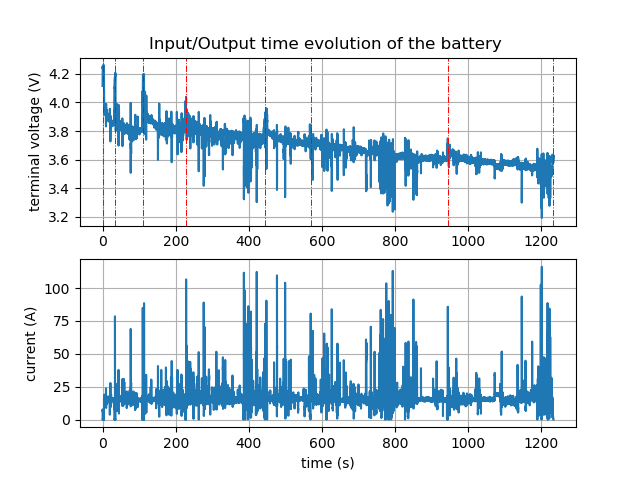

In [5]:
%matplotlib notebook
plt.figure()
plt.subplot(211)
plt.plot(time,voltage)
for tstop in tstoplist:
    plt.axvline(tstop,color='r',linestyle='-.',linewidth=0.7)
plt.ylabel('terminal voltage (V)')
plt.title('Input/Output time evolution of the battery ')
plt.grid()
plt.subplot(212)
plt.plot(time,current)
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


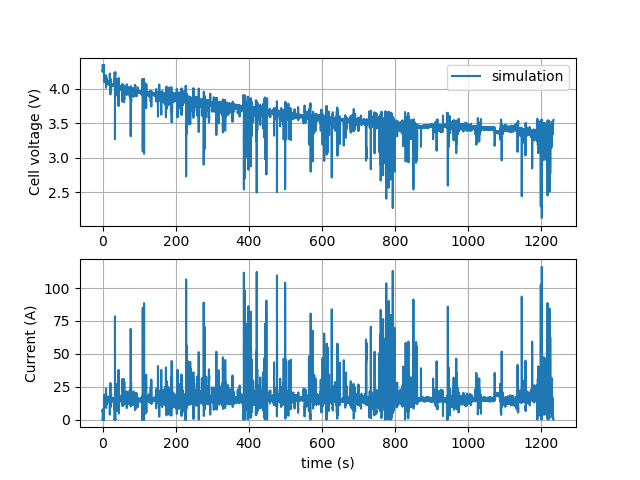

In [6]:
# function to be minimized
def rmserror(x):
    y = x[-n:]
    rmserror = (np.mean((y-voltage)**2))**.5
    return rmserror

# initial guess
ECparams = pd.read_csv('ECparams.csv')
x0 = np.array([ECparams['R0'], ECparams['R1'], ECparams['C1']])
initbat = battery.Thevenin(z0,Q,curve,ECparams['R0'],ECparams['R1'],ECparams['C1'])
vsim = initbat.simulate(time,current,curve)
x0 = np.append(x0,initbat.simz)
x0 = np.append(x0,initbat.simi1)
x0 = np.append(x0,initbat.simv)

In [ ]:
print(f'x0 has lenght {len(x0)}')
print(n)
print(f'z has length {len(initbat.simz)}')
print(f'iR1 has length {len(initbat.simi1)}')
print(f'v has length {len(initbat.simv)}')
print(len(x0[3+2*(n+1):]))
print(len(x0[-n:]))

In [ ]:
# x = [R0,R1,C1,z[0],z[1],...,z[k],...,z[n],iR1[0],iR1[1],...,iR1[k],...,iR1[n],y[0],y[1],...,y[k],...,y[n-1]]
#    x[0, 1, 2,  3,   4,..., k+3, ..., n+3, n+4,   n+5, ...,  n+k+4,..., 2*n+4,2*n+5,2*n+6,...,2*n+k+5,3*n+4] 
cons = []

def state1_eq(x):
    print('working ...')
    return x[3]-z0

def state2_eq(x):
    print('working ...')
    return x[n+4] # has to be equal to zero

con1 = {'type':'eq','fun':state1_eq}   
con2 = {'type':'eq','fun':state2_eq}     
cons.append(con1)
cons.append(con2)

for k in range(n):
    def state1_eq(x):
        print('working ...')
        return x[k+4]-x[k+3]+eta*dt/Q*current[k]
    
    def state2_eq(x):
        print('working ...')
        return x[n+k+5]-np.exp(-dt/(x[1]*x[2]))*x[n+k+4]-(1-np.exp(-dt/(x[1]*x[2])))*current[k]
    
    def output_eq(x):
        print('working ...')
        return x[2*n+k+5] - curve.OCVfromSOC(x[k+3]) + x[1]*x[n+k+4] + x[0]*current[k] 
    
    con1 = {'type':'eq','fun':state1_eq}   
    con2 = {'type':'eq','fun':state2_eq}   
    con3 = {'type':'eq','fun':output_eq}   
    cons.append(con1)
    cons.append(con2)
    cons.append(con3)

In [ ]:
dt = np.mean(np.diff(time))
print(type(initbat.simi1[1].values))
print(initbat.simi1[1].values)

In [ ]:
# definition of the bounds (the parameters and the variables cannot be negative)
bnd = tuple((0,None) for _ in range(len(x0)))
optimize.show_options(solver='minimize')

In [ ]:
# maximum of iterations
opt = {'maxiter':30}
results = optimize.minimize(rmserror,x0,method='SLSQP',options=opt,constraints=cons,bounds=bnd)

In [ ]:
print(len(results.x))
print(len(x0))
print(len(time))
print(n)

In [ ]:
optbattery = battery.Thevenin(z0,Q,curve,results.x[0],results.x[1],results.x[2])
vsimopt = optbattery.simulate(time,current,curve)
opty = results.x[-n:]

In [ ]:
plt.figure()
plt.plot(time,voltage)
plt.plot(time,vsimopt)
plt.plot(time,opty,':')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('terminal voltage (V)')

In [ ]:
optrms = (np.mean((opty-voltage)**2))**.5
print(optrms)
print(cons[1:3])

In [ ]:
cons_viol = [cons[k]['fun'](results.x) for k in range(len(cons))]

In [ ]:
np.any(cons_viol)

In [ ]:
np.unique(cons_viol)